In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 4
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import seaborn as sns
from sklearn.decomposition import PCA
import os
os.chdir('../')
from data_processing import helper_functions
os.chdir('notebooks')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [41]:
df = pd.read_csv('../formatted_data/all_data.csv')

In [54]:
df['date'] = pd.to_datetime(df['date'])
mobility_columns = df.columns[2:7]

In [43]:
df_transformed = helper_functions.transform_data_with_pca(df)
df_transformed['day_of_the_year'] = df_transformed['date'].dt.day_of_year
df_transformed.to_csv('../formatted_data/transformed_data.csv', index=False)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_18062/4006585688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['day_of_the_year'] = df_transformed['date'].dt.day_of_year


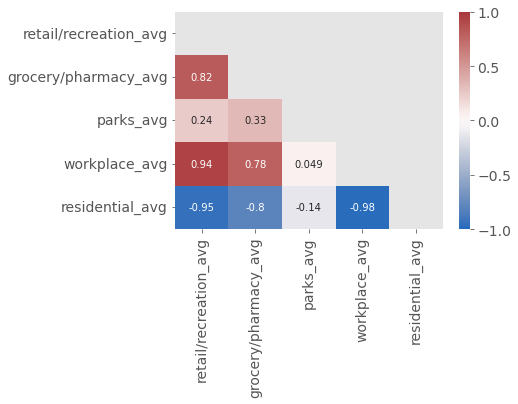

In [44]:
def make_corr_mat(df):
    fig = plt.figure(facecolor='white')
    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    df_corr = df[mobility_columns]
    sns.heatmap(df_corr.corr(), cmap='vlag',vmin=-1, vmax=1, annot=True, mask=np.triu(df_corr.corr()))
    return df_corr, fig
df_corr, fig = make_corr_mat(df)
plt.savefig('../figures/corr_matrix.png',dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

In [57]:
# plot first two components
pca = PCA(n_components=2)
pca.fit(df_corr)
components = pd.DataFrame(np.round(pca.components_, 3))
components.columns = df_corr.columns
components

,retail/recreation_avg,grocery/pharmacy_avg,parks_avg,workplace_avg,residential_avg
0,0.257,0.158,0.937,0.158,-0.082
1,-0.594,-0.263,0.336,-0.634,0.251


In [58]:
pca.explained_variance_ratio_.sum()

0.9781674114479255

In [59]:
grouped_df = df_transformed.groupby('department_name')

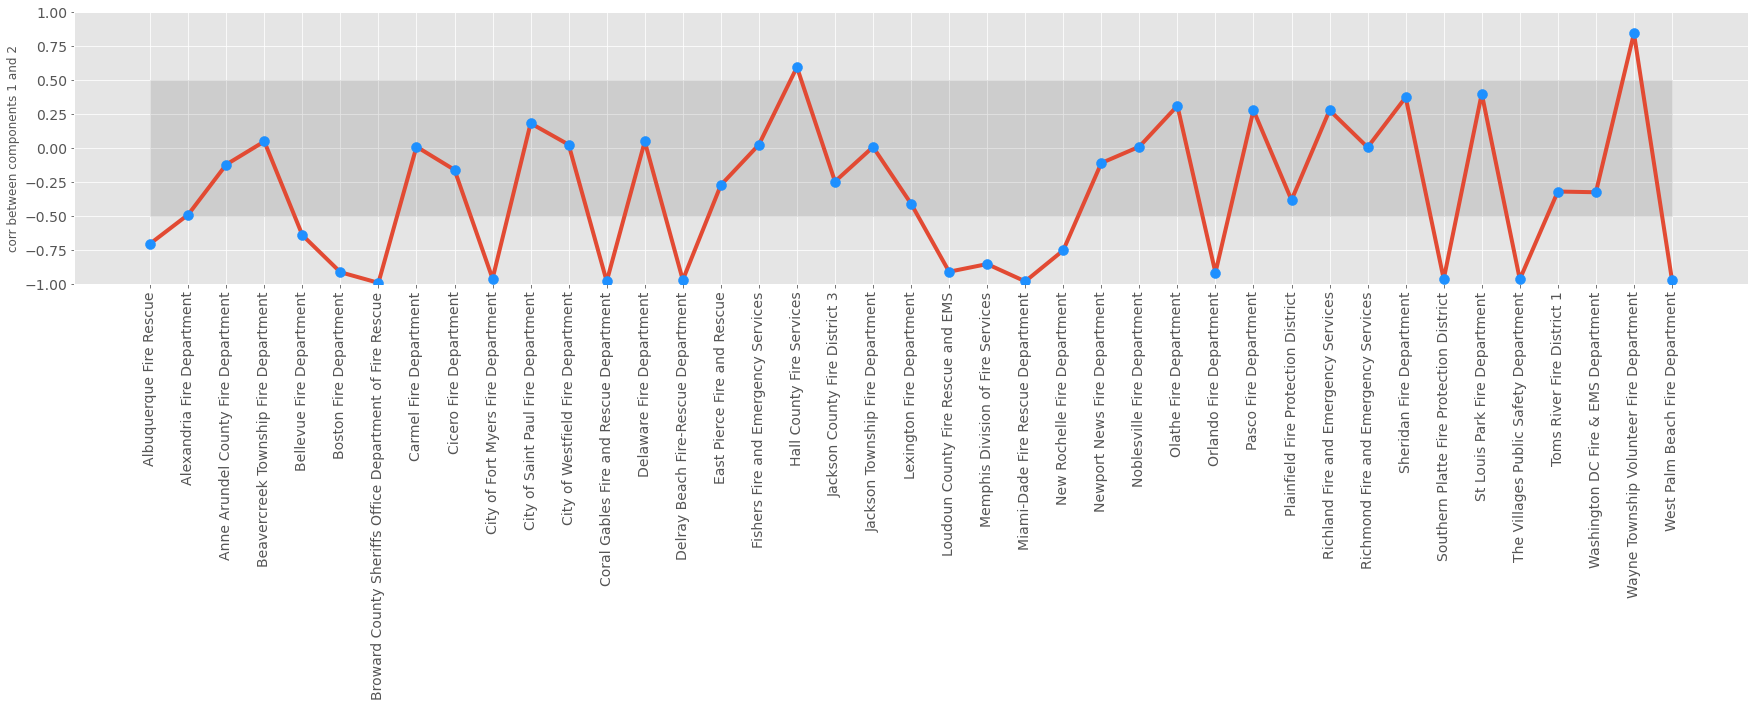

In [60]:
pca_correlations = grouped_df.apply(lambda x: x['component_1'].corr(x['component_2'])).to_frame(name='corr').reset_index()
fig = plt.figure(figsize=(30, 5), facecolor='white')
ticks = list(grouped_df.groups.keys())
plt.plot(ticks, pca_correlations['corr'])
plt.scatter(ticks, pca_correlations['corr'], color='dodgerblue', s=100, zorder=3)
plt.xticks(ticks, rotation=90)
plt.fill_between(x=ticks, y1=np.full(len(ticks), -0.5), y2=np.full(len(ticks), 0.5), color='black', alpha=.1)
plt.ylabel('corr between components 1 and 2')
plt.ylim(-1, 1)
plt.savefig('../figures/corr_problem.png', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')

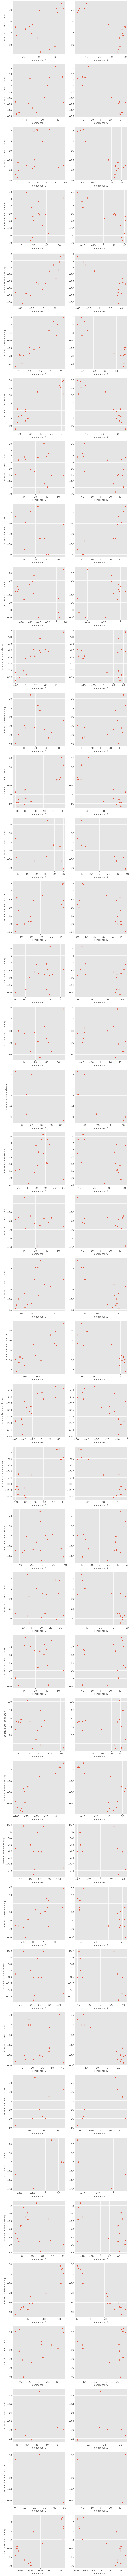

In [49]:
fig = plt.figure(figsize=(10, 200), facecolor='white')
plt.style.use('ggplot')
colors = ['red','dodgerblue']
for n, dept in enumerate(grouped_df.groups):
    df_dept = grouped_df.get_group(dept)
    plt.subplot(len(grouped_df.groups), 2, 2*n+1)
    plt.scatter(df_dept['component_1'], df_dept['avg_change_baseline_incidents'])
    plt.ylabel('incident baseline change')
    plt.xlabel('component 1')
    plt.subplot(len(grouped_df.groups), 2, 2*n+2)
    plt.scatter(df_dept['component_2'], df_dept['avg_change_baseline_incidents'])
    plt.xlabel('component 2')
plt.tight_layout()
plt.savefig('../figures/pca_plots.png', dpi=300, facecolor=fig.get_facecolor())

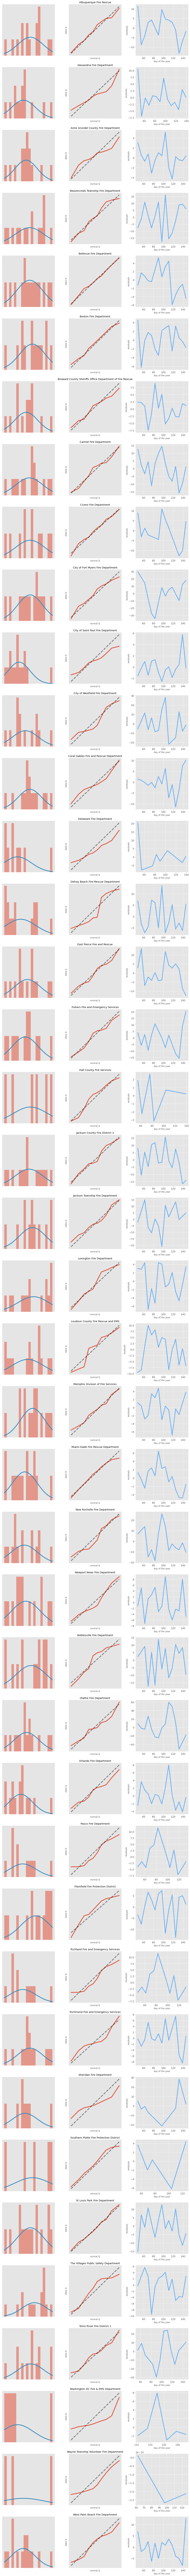

In [50]:
plt.figure(figsize=(15, 200))
    
for n, dept in enumerate(grouped_df.groups):
    df_dept = grouped_df.get_group(dept)
    plt.subplot(len(grouped_df.groups), 3, 3*n + 1)
    X, y = df_dept[['intercept', 'component_1', 'component_2']], df_dept['avg_change_baseline_incidents']
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    residuals = y - reg.predict(X)
    plt.hist(residuals, alpha=.5, density=True, bins=20)
    plt.xticks([])
    plt.yticks([])
    
    mean = np.mean(residuals)
    var = np.var(residuals)
    min_x, max_x = np.min(residuals), np.max(residuals)
    x = np.linspace(min_x, max_x, 100)
    normal = norm(loc=mean, scale=np.sqrt(var))
    norm_pdf = normal.pdf(x)
    plt.plot(x, norm_pdf)
    plt.subplot(len(grouped_df.groups), 3, 3*n + 2)
    plt.title(dept)

    
    quants = np.linspace(0.1, 0.9, 10)
    quantiles_norm = normal.ppf(quants)
    quantiles_data = np.quantile(residuals, quants)
    plt.plot(quantiles_norm, quantiles_data)
    plt.xlabel('normal Q')
    plt.ylabel('data Q')
    plt.xticks([])
    plt.yticks([])
    plt.plot([quantiles_norm.min(), quantiles_norm.max()],[quantiles_norm.min(), quantiles_norm.max()], color='black', alpha=.5, linestyle='--')
    plt.subplot(len(grouped_df.groups), 3, 3*n + 3)
    plt.plot(df_dept['day_of_the_year'], residuals, alpha=.6, color='dodgerblue')
    plt.xlabel('day of the year')
    plt.ylabel('residuals')
    
plt.tight_layout()    
    
plt.savefig('../figures/normal_approx.png',bbox_inches='tight', dpi=300)

In [51]:
all_days_2020 = pd.DataFrame(pd.date_range("2020", freq="D", periods=365))
all_days_2020.columns = ['date']
mondays_of_2020 = all_days_2020[all_days_2020['date'].dt.dayofweek == 0].reset_index(drop=True)

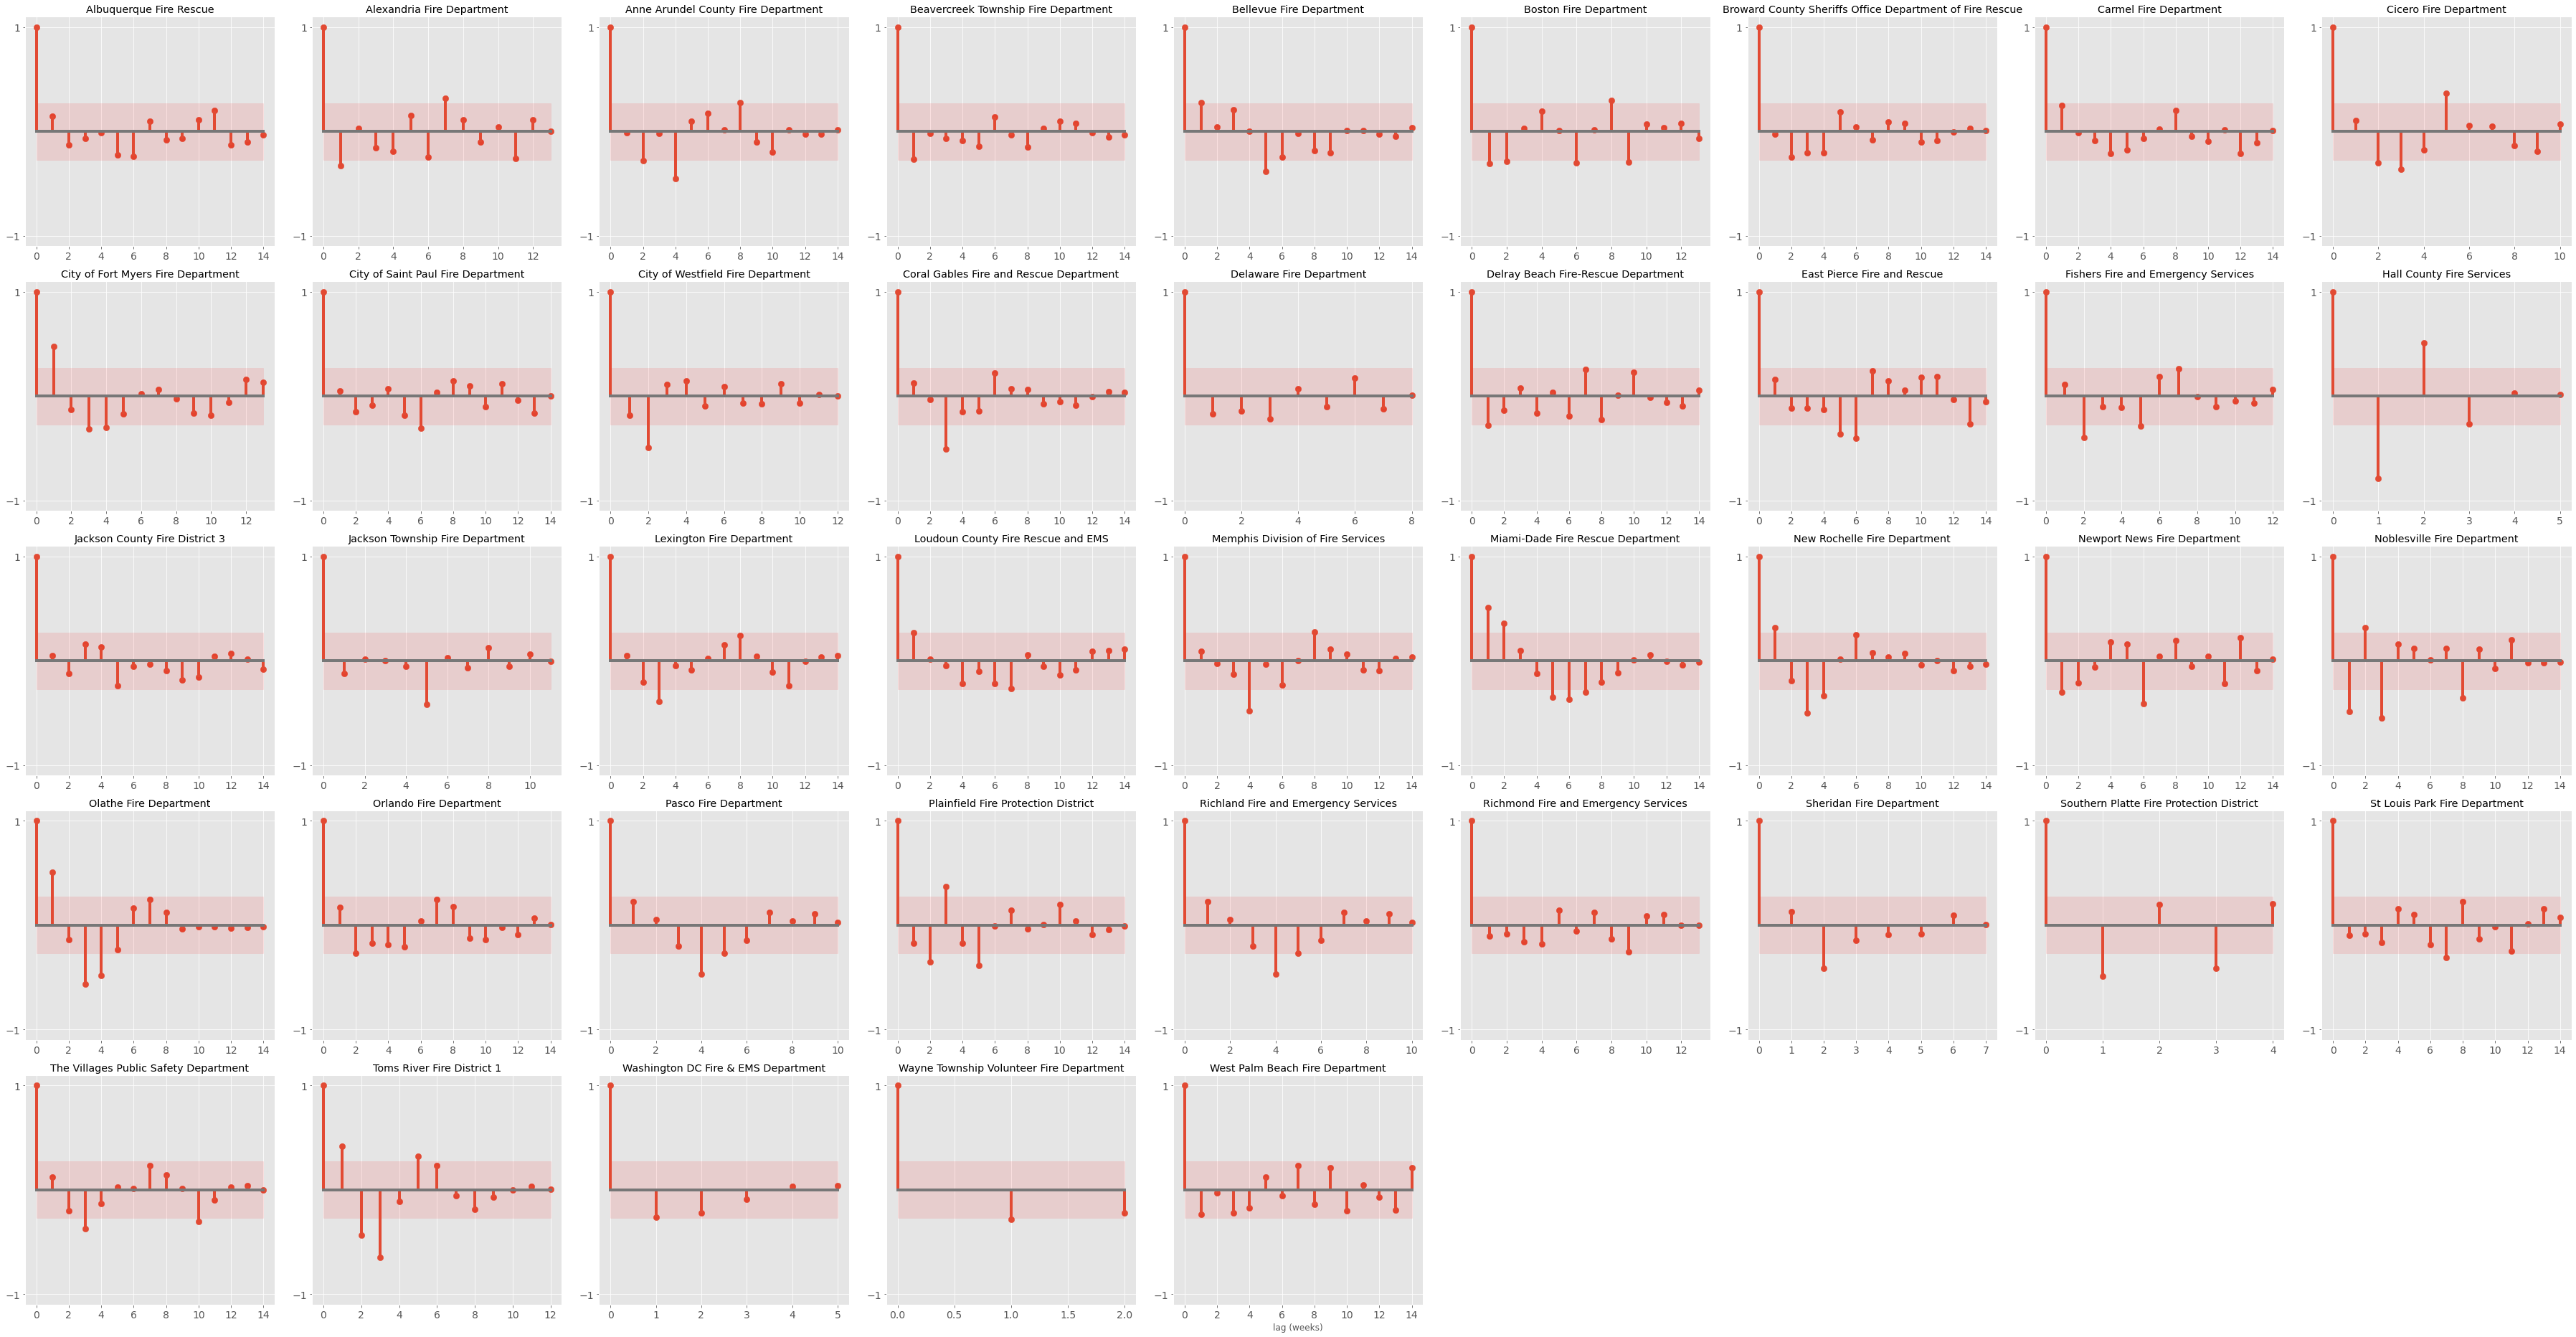

In [52]:
plt.figure(figsize=(50, 26))
for i, dept in enumerate(grouped_df.groups):
    df_dept = grouped_df.get_group(dept)
    plt.subplot(5, 9, i + 1)
    X, y = df_dept[['intercept', 'component_1', 'component_2']], df_dept['avg_change_baseline_incidents']
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    residuals = y - reg.predict(X)
    df_acf = pd.DataFrame()
    df_acf['date'] = df_dept['date']
    df_acf['residuals'] = residuals
    merged_df = pd.merge(mondays_of_2020, df_acf, how='outer', on='date').sort_values('date')
    data, confidence_interval = acf(merged_df['residuals'],  nlags=len(residuals)-1,  missing='drop', alpha=.05, bartlett_confint = False
)
    lags = np.arange(0, len(residuals), 1)
    plt.scatter(lags, data, s=70)
    _, stemlines, baseline = plt.stem(lags, data, markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 4)
    plt.setp(baseline, 'linewidth', 4)
    plt.ylim(-1.1,1.1)
    plt.yticks([-1,1])
    plt.fill_between(lags, confidence_interval[:,0]-data, confidence_interval[:,1]-data, alpha=.1, color='red')
    plt.title(dept)
    if i == 40:
        plt.xlabel('lag (weeks)')
    
plt.tight_layout()
plt.savefig('../figures/acf_plots.png',bbox_inches='tight', dpi=200)   
   